# <b><span style='color:#e61227'></span> Algorithmic Trading (DS4F) - Project Assignment 2023/2024


## Authors:
- Luís Ribeiro (nº 20231536)
- Renato Morais (nº 20231135)
- Fernando Tiago (nº 20231535)
- Thiago Bellas (nº 20231131)
- Saad Islam (nº 20230513)

  </b>

### <b>1 <span style='color:#e61227'>|</span> Choose a trading strategy and describe its rational.</b>

For our work we will be implementing and testing a technical indicator analysis strategy using Bollinger Bands and the RSI (Relative Strengh Index).

- Bollinger Bands consist of three lines: a 20-day simple MA (moving average) which will be the middle band; the upper band, and lower band, respectively corresponding to the MA several times (2 or 1.5) above/below the standard deviation. The more standard deviations, the less signals will be generated.
- RSI which is a momentum oscillator ranging from 0 to 100, within a day period. Generally, an RSI above 70 indicates an overbought condition and 30 an oversold one.

This strategy combines two technical indicators, the Relative Strength Index (RSI) and Bollinger Bands, to generate a buy signal when the price is below the lower Bollinger Bands and a sell signal when the price is above the upper Bollinger Bands. This strategy only triggers a trading signal when the RSI indicator and the Bollinger Bands indicator are both oversold or overbought.

### <b>2 <span style='color:#e61227'>|</span> Fetch data for a period greater than 5 years for the asset or assets you intend to test.</b>

In [ ]:
!pip install backtrader
!pip install plotly
!pip install backtrader-plotly==1.5.0
%matplotlib inline

In [ ]:
import yfinance as yf
import backtrader as bt

def get_data(symbol: str):
    data = yf.download(tickers=symbol, start='2017-01-01', end='2024-04-01', auto_adjust=True)
    #data.reset_index(inplace=True, drop=True)
    return data

data = get_data('AAPL')

test_days = 251

train_data = data.iloc[:-test_days]
test_data = data.iloc[-test_days:]

train_data.tail()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
2023-03-23,157.772730,160.474625,156.630376,157.872055,67622100
2023-03-24,157.802527,159.272671,156.799255,159.183273,59196500
2023-03-27,158.875333,159.699810,156.819105,157.226379,52390300
2023-03-28,156.918433,157.434975,154.941674,156.600555,45992200
2023-03-29,158.309139,159.977964,158.289283,159.699829,51305700


### <b>3 <span style='color:#e61227'>|</span> Write clear trading rules to generate signals for your trades</b>

The trading rules for this strategy are very simple:
- Buy if RSI < 30 (oversold) and close price < lower BB (Bollinger Band) if we can buy at least 1 share and it's less than 0.5% of volume (as to not move price one way and to prevent buying more than available). If we can buy more than available, then we cap it.
- Sell if RSI > 70 (overbought) and close price > upper BB and we have shares to sell (we have a position)

In [ ]:
class RsiBollingerStrategy(bt.Strategy):

    params = (
          ('bb_period', 20),
          ('bb_stdev', 1.5),
          ('rsi_period', 14),
          ('volume_limit', 0.5/100), #0.5% of available volume
    )

    def __init__(self):
        #Bollinger Bands
        self.bb = bt.indicators.BollingerBands(
            self.data.close,
            period=self.params.bb_period,
            devfactor=self.params.bb_stdev
        )
        #RSI
        self.rsi = bt.indicators.RSI_SMA(self.data.close, period=self.params.rsi_period)

    def next(self):
        #how much cash we have on hand
        available_cash = self.broker.cash
        #how much we could buy if there was no limit
        purchasable_shares = available_cash//self.data.close[0]
        #how many shares from the volume are purchasable within limit
        share_volume_limit = int(self.data.volume[0] * self.params.volume_limit)

        if not self.position and self.rsi < 30 and self.data.close[0] <= self.bb.lines.bot:
            #if we can afford at least 1 share, buy as much as we can up to a % of available volume
            if purchasable_shares > 0:
                shares_to_buy = purchasable_shares if purchasable_shares < share_volume_limit else share_volume_limit
                #print(f"{self.datas[0].datetime.date(0)} ~ Bought {shares_to_buy} at {self.data.close[0]}")
                self.buy(size=shares_to_buy)
        if self.position and self.rsi > 70 and self.data.close[0] >= self.bb.lines.top:
            #print("Closed position ", self.datas[0].datetime.date(0))
            self.close()

    def stop(self):
        self.close()
        print('==================================================')
        print(f'Starting Value: {self.broker.startingcash:,.2f}')
        print(f'Ending   Value: {self.broker.getvalue():,.2f}')
        print('==================================================')


### <b>4 <span style='color:#e61227'>|</span> Choose and describe at least 3 performance measures used in the backtesting analysis with a short description of the results</b>

For performance measures, we will use:
- Max drawdown: Max drawdown is a measure of the largest single drop from peak to trough in the value of an investment portfolio before a new peak is achieved. It represents the maximum observed loss. So if we have a maximum DD (drawdown) of 50%, it means at somepoint we could've lost 50% of our portfolio value.

- Sharpe Ratio: The Sharpe ratio describes how much excess return we receive for each additional unit of risk assumed. A higher ratio implies a higher investment return compared to the amount of risk of the investment. A good Sharpe ratio is at least above 1. Below 1 means that it's more risky than profitable, while being 1 means it's as much profitable as risky.

- CAGR: The Compound Annual Growth Rate (CAGR) is a financial ratio used to calculate the benefit an investor will receive in relation to their investment cost over a span of time, assuming reinvestment. A CAGR of 2% for a 5 year investment means over the 5 years we have increased our value by 2%, not yearly returns.

For the backtesting analysis with these values, please check the next point of the assignments (with results for in-sample testing).

### <b>5 <span style='color:#e61227'>|</span> Optimize and backtest your chosen strategy, leaving at least one full year out of the training data to test the strategy out of sample.<br>Describe the target variable used to optimize and justify your choice</b>

We'll now perform a backtest for the training data. We'll be using BB Bands with a 20-day period and 1.5 standard deviations, and an 14-day RSI. For optimization we're mainly looking at the Sharpe Ratio because it's a more complete variable than just portfolio value, since it takes into account the risk taken. **Note: for the Sharpe Ratio calculation, to simplify we'll assume a 0% risk-free rate and no trading commissions/fees.**

Starting Value: 100,000.00
Ending   Value: 137,543.15
CAGR:				5.250%
Sharpe Ratio:			0.683
Max Drawdown:			25.753%


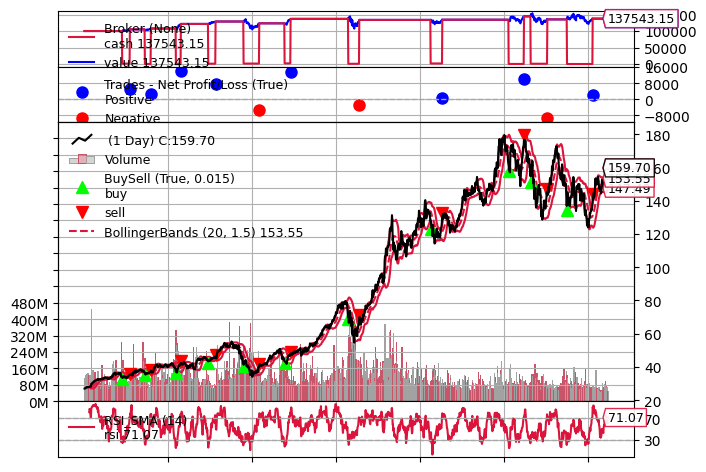

In [ ]:
from backtrader.feeds import PandasData
from backtrader_plotly.plotter import BacktraderPlotly
from backtrader_plotly.scheme import PlotScheme
import plotly.io

def get_cerebro(data, strategy = RsiBollingerStrategy, cash = 100000):
  cerebro = bt.Cerebro()
  cerebro.adddata(PandasData(dataname=data))
  cerebro.addstrategy(strategy)
  cerebro.broker.setcash(cash)
  #Analyzers
  cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe', riskfreerate=0)
  cerebro.addanalyzer(bt.analyzers.DrawDown, _name='dd')
  cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
  cerebro.addanalyzer(bt.analyzers.Transactions, _name='trades')
  #return cerebro
  return cerebro

def backtest(cerebro):
  #run backtest
  cerebro_run = cerebro.run()
  print(f"CAGR:\t\t\t\t{cerebro_run[0].analyzers.returns.get_analysis()['rnorm']:.3%}")
  print(f"Sharpe Ratio:\t\t\t{cerebro_run[0].analyzers.sharpe.get_analysis()['sharperatio']:.3f}")
  print(f"Max Drawdown:\t\t\t{cerebro_run[0].analyzers.dd.get_analysis()['max']['drawdown']:.3f}%")
  #plot result
  cerebro.plot(iplot=False)
  #cerebro.plot(BacktraderPlotly(show=True, scheme=PlotScheme(decimal_places=3, max_legend_text_width=16))) #plotly plot for debug...

backtest(get_cerebro(train_data))

Looking above we can see that we generated a CAGR of 5.25% for a bit more than 6 years. Meaning we would've gotten after 6 years of investment in this strategy 5.25% return on our money.

The Sharpe Ratio is subpar, being 0.683, meaning that the risk taken is bigger than the profit - considering a risk-free rate of 0% (if we considered a real rate, it would've been negative).

The maximum drawdown is also not good being 25.753%. In other words, at a worse case scenario, we could lose 25.753% of our investment value.

---------------------------------------------------------------



It's therefore necessary to implement some optimizations on our strategy. Looking at the results above we can see the price often collides with the Bollinger bands. This can happen if either our standard deviation is too low, or we're dealing with a high volatility asset.

In this case, we're using 1.5 which is standard, so it comes to reason that our asset might be highly volatile. To check this, we can plot for the training data the price returns along with an annualized volatility.

Annualized volatility:  0.311779884633678
Mean return:  0.0013274652990321694


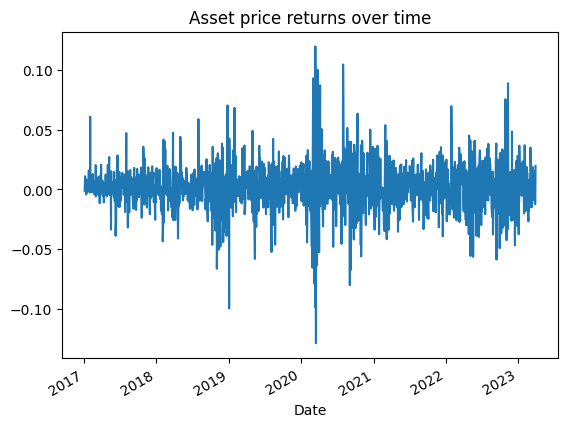

In [ ]:
import numpy as np

print("Annualized volatility: ", train_data.Close.pct_change().std() * np.sqrt(252))
print("Mean return: ", train_data.Close.pct_change().mean())
train_data.Close.pct_change().plot(title="Asset price returns over time");

Looking above, we can see that the annualized volatility is roughly 31%, which is high; the plot seems to suggest the same, being that the mean daily return is near 0, but there are several returns exceeding this. Therefore, we are dealing with a highly volatile asset.

Our new strategy should therefore take this into consideration, and extend the Bollinger band deviations further. For testing, we'll now assume a 2.5 standard deviation.

Starting Value: 100,000.00
Ending   Value: 192,349.39
CAGR:				11.071%
Sharpe Ratio:			0.901
Max Drawdown:			25.754%


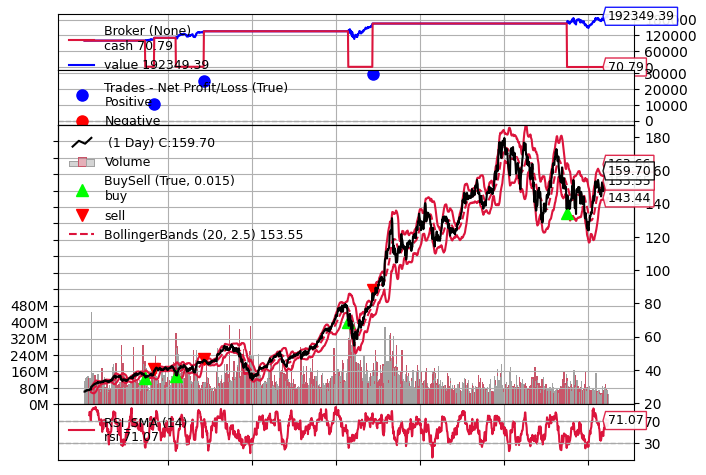

In [ ]:
class VolatileRsiBollingerStrategy(bt.Strategy):

    params = (
          ('bb_period', 20),
          ('bb_stdev', 2.5),
          ('rsi_period', 14),
          ('volume_limit', 0.5/100), #0.5% of available volume
    )

    def __init__(self):
        #Bollinger Bands
        self.bb = bt.indicators.BollingerBands(
            self.data.close,
            period=self.params.bb_period,
            devfactor=self.params.bb_stdev
        )
        #RSI
        self.rsi = bt.indicators.RSI_SMA(self.data.close, period=self.params.rsi_period)

    def next(self):
        #how much cash we have on hand
        available_cash = self.broker.cash
        #how much we could buy if there was no limit
        purchasable_shares = available_cash//self.data.close[0]
        #how many shares from the volume are purchasable within limit
        share_volume_limit = int(self.data.volume[0] * self.params.volume_limit)

        if not self.position and self.rsi < 30 and self.data.close[0] <= self.bb.lines.bot:
            #if we can afford at least 1 share, buy as much as we can up to a % of available volume
            if purchasable_shares > 0:
                shares_to_buy = purchasable_shares if purchasable_shares < share_volume_limit else share_volume_limit
                #print(f"{self.datas[0].datetime.date(0)} ~ Bought {shares_to_buy} at {self.data.close[0]}")
                self.buy(size=shares_to_buy)
        if self.position and self.rsi > 70 and self.data.close[0] >= self.bb.lines.top:
            #print("Closed position ", self.datas[0].datetime.date(0))
            self.close()

    def stop(self):
        self.close()
        print('==================================================')
        print(f'Starting Value: {self.broker.startingcash:,.2f}')
        print(f'Ending   Value: {self.broker.getvalue():,.2f}')
        print('==================================================')

backtest(get_cerebro(train_data, strategy=VolatileRsiBollingerStrategy))

The optimization was made considering a 2.5 times standard deviation, which mean we assumed more risk in our returns. What we obtained was an increase in the returns, in the Sharpe Ratio, and a reduction of the Max Drawdown.
Since we're with expanded Bollinger bands, there is a reduction in trading signals because the price collision with wider bands is less likely.

----------------------------------------------------

Another thing we can try to deal with the high volatility, is the base strategy (without extending the bands) but with a stoploss of 5%. This means that whenever we're holding an asset and it depreciates 5%, we'll close our position.

Starting Value: 100,000.00
Ending   Value: 109,959.96
CAGR:				1.536%
Sharpe Ratio:			0.190
Max Drawdown:			16.990%


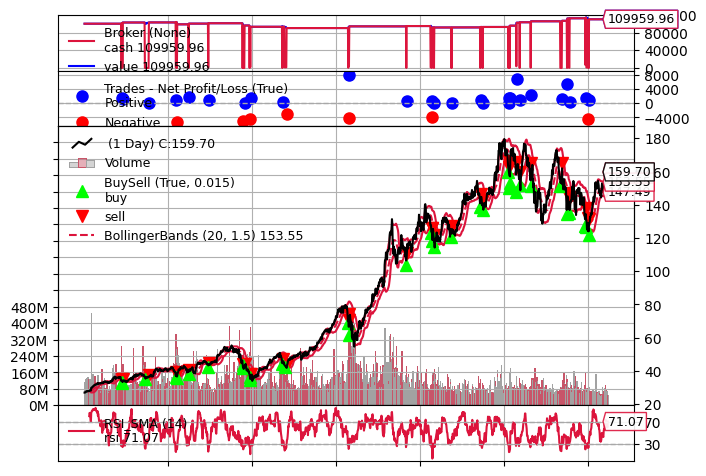

In [ ]:
class StopLossRsiBollingerStrategy(bt.Strategy):

    params = (
          ('bb_period', 20),
          ('bb_stdev', 1.5),
          ('rsi_period', 14),
          ('volume_limit', 0.5/100), #0.5% of available volume
          ('stop_loss', 5/100)
    )

    def __init__(self):
        #Bollinger Bands
        self.bb = bt.indicators.BollingerBands(
            self.data.close,
            period=self.params.bb_period,
            devfactor=self.params.bb_stdev
        )
        #RSI
        self.rsi = bt.indicators.RSI_SMA(self.data.close, period=self.params.rsi_period)

    def next(self):
        #how much cash we have on hand
        available_cash = self.broker.cash
        #how much we could buy if there was no limit
        purchasable_shares = available_cash//self.data.close[0]
        #how many shares from the volume are purchasable within limit
        share_volume_limit = int(self.data.volume[0] * self.params.volume_limit)

        if not self.position and self.rsi < 30 and self.data.close[0] <= self.bb.lines.bot:
            #if we can afford at least 1 share, buy as much as we can up to a % of available volume
            if purchasable_shares > 0:
                shares_to_buy = purchasable_shares if purchasable_shares < share_volume_limit else share_volume_limit
                #stop-loss price
                limit_price = self.data.close[0] * (1-self.params.stop_loss)
                #issue buy with stop-loss
                self.buy_bracket(price=self.data.close[0], stopprice=limit_price, size=shares_to_buy)
        if self.position and self.rsi > 70 and self.data.close[0] >= self.bb.lines.top:
            #print("Closed position ", self.datas[0].datetime.date(0))
            self.close()

    def stop(self):
        self.close()
        print('==================================================')
        print(f'Starting Value: {self.broker.startingcash:,.2f}')
        print(f'Ending   Value: {self.broker.getvalue():,.2f}')
        print('==================================================')

backtest(get_cerebro(train_data, strategy=StopLossRsiBollingerStrategy))

We can see there is not much improvement since the bands are still tight. But trying with the wider bands (since the stock is volatile) yields the following:

Starting Value: 100,000.00
Ending   Value: 115,508.15
CAGR:				2.341%
Sharpe Ratio:			1.102
Max Drawdown:			6.446%


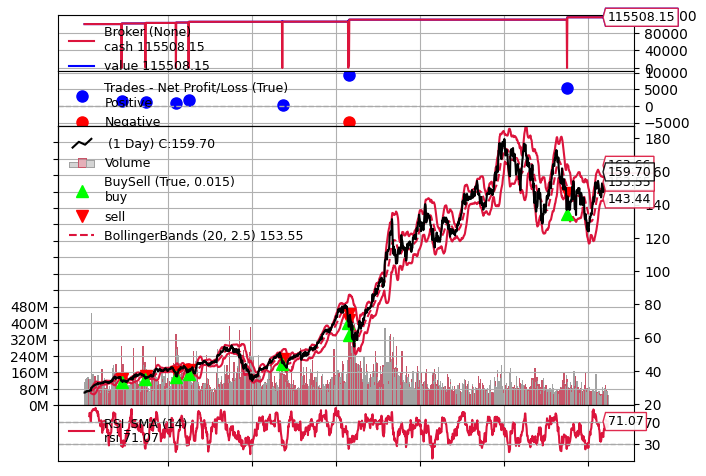

In [ ]:
class StopLossVolatileRsiBollingerStrategy(bt.Strategy):

    params = (
          ('bb_period', 20),
          ('bb_stdev', 2.5),
          ('rsi_period', 14),
          ('volume_limit', 0.5/100), #0.5% of available volume
          ('stop_loss', 5/100)
    )

    def __init__(self):
        #Bollinger Bands
        self.bb = bt.indicators.BollingerBands(
            self.data.close,
            period=self.params.bb_period,
            devfactor=self.params.bb_stdev
        )
        #RSI
        self.rsi = bt.indicators.RSI_SMA(self.data.close, period=self.params.rsi_period)

    def next(self):
        #how much cash we have on hand
        available_cash = self.broker.cash
        #how much we could buy if there was no limit
        purchasable_shares = available_cash//self.data.close[0]
        #how many shares from the volume are purchasable within limit
        share_volume_limit = int(self.data.volume[0] * self.params.volume_limit)

        if not self.position and self.rsi < 30 and self.data.close[0] <= self.bb.lines.bot:
            #if we can afford at least 1 share, buy as much as we can up to a % of available volume
            if purchasable_shares > 0:
                shares_to_buy = purchasable_shares if purchasable_shares < share_volume_limit else share_volume_limit
                #stop-loss price
                limit_price = self.data.close[0] * (1-self.params.stop_loss)
                #issue buy with stop-loss
                self.buy_bracket(price=self.data.close[0], stopprice=limit_price, size=shares_to_buy)
        if self.position and self.rsi > 70 and self.data.close[0] >= self.bb.lines.top:
            #print("Closed position ", self.datas[0].datetime.date(0))
            self.close()

    def stop(self):
        self.close()
        print('==================================================')
        print(f'Starting Value: {self.broker.startingcash:,.2f}')
        print(f'Ending   Value: {self.broker.getvalue():,.2f}')
        print('==================================================')

backtest(get_cerebro(train_data, strategy=StopLossVolatileRsiBollingerStrategy))

We can now see with the latest assumption of a volatile stock that the stop-loss method at 5% has decrease CAGR but significantly lowered the Max Drawdown and increased Sharpe Ratio to acceptable levels.
This happened because we're now closing positions that start being unprofitable instead of holding them...

This, in our view, is the most optimized model so far.

### <b>6 <span style='color:#e61227'>|</span> What would have been the P/L and the risk measures of the strategy during the backtest and out of sample? Comment the results</b>

Starting Value: 100,000.00
Ending   Value: 115,508.15
CAGR:				2.341%
Sharpe Ratio:			1.102
Max Drawdown:			6.446%


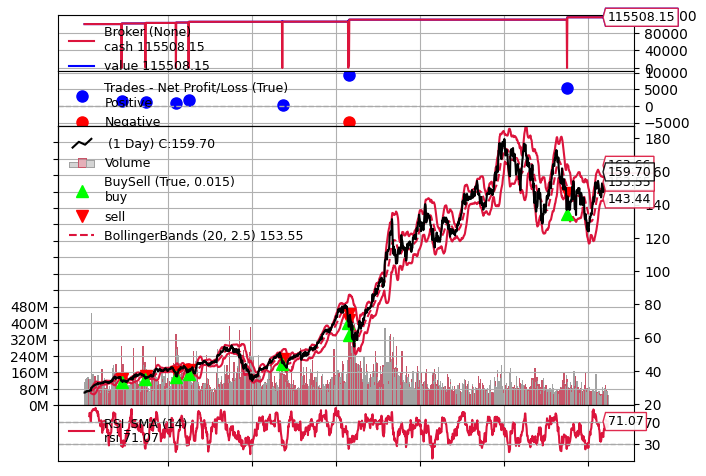

In [ ]:
backtest(get_cerebro(train_data, strategy=StopLossVolatileRsiBollingerStrategy))

Using our improvements we can see that we obtain better results, seeming that adding a stop loss reduced the risk on our trades and thus increasing our overall Sharpe Ratio. In terms of P/L, we made more than $15000 over a several year period (about 5/6 years) resulting in a CAGR of 2.341%.

Starting Value: 100,000.00
Ending   Value: 95,885.78
CAGR:				-4.130%
Sharpe Ratio:			-0.641
Max Drawdown:			5.691%


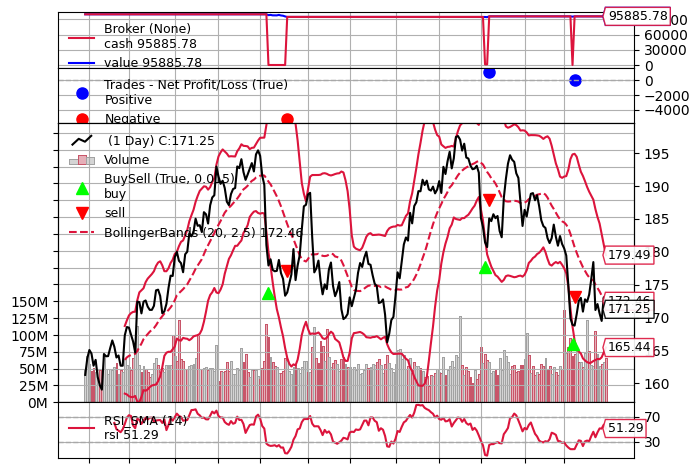

In [ ]:
backtest(get_cerebro(test_data, strategy=StopLossVolatileRsiBollingerStrategy))

Unfortunately having optimized for our training set we did not obtain positive results for the out-of-sample test set.

Analyzing the metrics, we see that for about a year investment in this strategy we have lost roughly 4% and achieved a negative Sharpe Ratio. At the worse point of this strategy, we could expect to lose about 5.7% of portfolio value.

There are several reasons why this happened:

*   We cannot predict the future looking backwards: the previous Bollinger band was optimized for a historical volatility that did not apply here. This resulted in wider bands while they should've been narrower.
*   The overall trend during this out-of-sample period is downwards, which means that the opportunities for buying at the bottom and selling at the top were reduced since the asset value kept decreasing. This means that not as much signals for entry will be made since the bands are too wide to trigger a buy/sell.
*   A real-world possibility: the asset during the out-of-sample period did not perform as well as during the training period.




### <b>7 <span style='color:#e61227'>|</span> Choose two assets to build a pairs trading strategy. Perform an initial analysis to verify if the two assets are appropriate to be traded in this strategy and backtest your strategy explaining your assumptions and results.</b>




This code provides two key functions for analyzing financial time series data. The `are_cointegrated` function determines if two asset time series, `asset_A` and `asset_B`, are cointegrated by fitting an Ordinary Least Squares (OLS) regression of `asset_A` on `asset_B` and then applying the Augmented Dickey-Fuller (ADF) test on the residuals to check for stationarity. If the residuals are stationary, the assets are considered cointegrated, and the function returns this result along with the full ADF test output. The `check_stationarity` function evaluates whether a given time series is stationary by performing the ADF test, returning a boolean indicating stationarity based on a specified significance level (default 0.05) and the corresponding p-value of the test.

In [ ]:
from scipy.stats import linregress
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
import pandas as pd
import numpy as np
import statsmodels.api as sm

def are_cointegrated(asset_A, asset_B):
    model = sm.OLS(asset_A, sm.add_constant(asset_B)).fit()
    adf_result = adfuller(model.resid)
    return adf_result[0] < adf_result[4]['5%'], adf_result

def check_stationarity(series, significance_level=0.05):
    adf_test = adfuller(series, autolag='AIC')
    p_value = adf_test[1]
    is_stationary = p_value < significance_level
    return is_stationary, p_value


In [ ]:
possible_pairs = (
    ('XOM','CVX'),
    ('SHEL','BP'),
    ('GS','MS'),
    ('AAPL', '^IXIC'),
    ('KO','PEP'),
    ('BTC-USD', 'ETH-USD'),
    ('AAPL', 'MSFT'),
    ('AAPL', '1810.HK'),
    ('MA', 'V'),
    ('SHEL', 'BP')
)

for idx, pair in enumerate(possible_pairs):
    try:
        pair_data = yf.download(pair, start='2015-01-01', end='2023-12-30', progress=False)['Adj Close'].dropna()
        asset_A, asset_B = pair_data[pair[0]], pair_data[pair[1]]
        result = are_cointegrated(asset_A, asset_B)
        print(pair, " -> Cointegrated: ", result[0], " $ index -> " + str(idx) if result[0] else "")
    except Exception as e:
        print(f"Error processing pair {pair}: {e}")

('XOM', 'CVX')  -> Cointegrated:  False 
('SHEL', 'BP')  -> Cointegrated:  True  $ index -> 1
('GS', 'MS')  -> Cointegrated:  True  $ index -> 2
('AAPL', '^IXIC')  -> Cointegrated:  False 
('KO', 'PEP')  -> Cointegrated:  True  $ index -> 4
('BTC-USD', 'ETH-USD')  -> Cointegrated:  True  $ index -> 5
('AAPL', 'MSFT')  -> Cointegrated:  False 
('AAPL', '1810.HK')  -> Cointegrated:  False 
('MA', 'V')  -> Cointegrated:  True  $ index -> 8
('SHEL', 'BP')  -> Cointegrated:  True  $ index -> 9


The analysis of asset pairs for cointegration indicates whether each pair is cointegrated. For example, the pair ('XOM', 'CVX') is not cointegrated, while the pair ('SHEL', 'BP') is cointegrated, indexed at 1. This pattern continues for other asset pairs, with some showing cointegration and others not.

chosen pair ->  ('SHEL', 'BP')


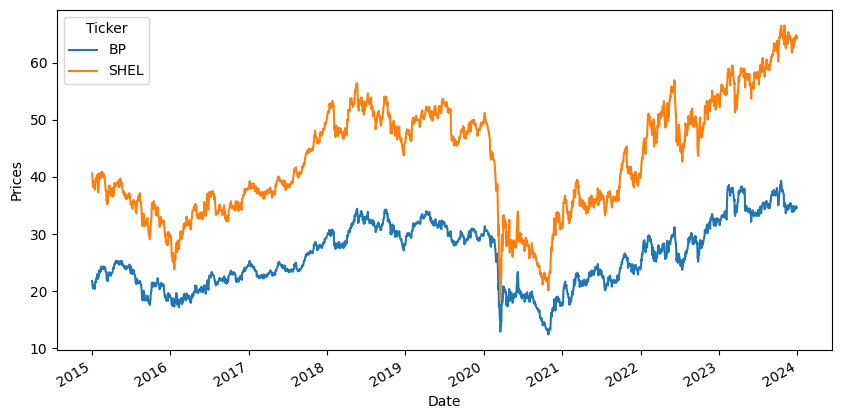

In [ ]:
import matplotlib.pyplot as plt

chosen_pair = possible_pairs[9]
print("chosen pair -> ", chosen_pair)

pair_data = yf.download(chosen_pair, '2015-01-01', end='2023-12-30', progress=False)['Adj Close'].dropna()
pair_data.plot(figsize=(10,5))
plt.ylabel('Prices')
plt.xlabel('Date')
plt.show()

The graph depicts the historical prices of BP and SHEL from 2015 to 2024. Despite their individual price fluctuations, the two series exhibit a similar overall trend, moving in parallel over time. This visual parallel movement suggests a cointegrated relationship, meaning that although each stock's price may vary independently in the short term, their long-term movements are linked, maintaining a stable relationship. This is consistent with the earlier analysis indicating that BP and SHEL are cointegrated.

Checking stationarity for SHEL/BP ratio/spread: (True, 0.005352237827559109)
------------------------------
Checking stationarity for BP/SHEL ratio/spread: (True, 0.004346703457792834)


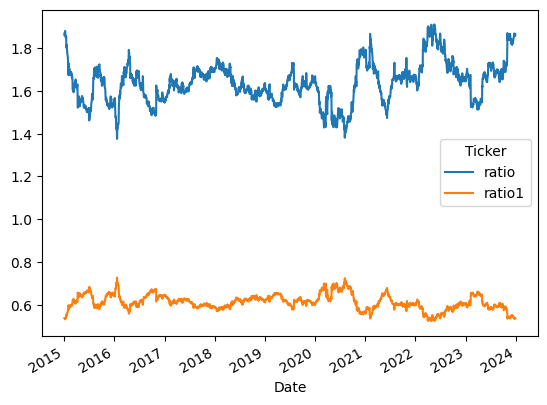

In [ ]:
import yfinance as yf
from statsmodels.tsa.stattools import adfuller

pair_data['ratio'] = pair_data[chosen_pair[0]] / pair_data[chosen_pair[1]]
pair_data['ratio1'] = pair_data[chosen_pair[1]] / pair_data[chosen_pair[0]]

print(f"Checking stationarity for {chosen_pair[0]}/{chosen_pair[1]} ratio/spread:", check_stationarity(pair_data['ratio'], significance_level=0.05))
print("-" * 30)
print(f"Checking stationarity for {chosen_pair[1]}/{chosen_pair[0]} ratio/spread:", check_stationarity(pair_data['ratio1'], significance_level=0.05))

pair_data[['ratio','ratio1']].plot();

Looking at the graph we can see that both ratios exhibit a relatively stable pattern over time, with no clear trend upwards or downwards, suggesting stationarity. This implies that despite short-term fluctuations, the ratios revert to a mean level, indicating that the underlying series are likely stationary. This stability over the long term is a key characteristic of stationary time series, supporting the earlier analysis that these pairs maintain a consistent relationship.

Our strategy is a mean-reversion trading strategy, focusing on trading pairs of assets. It utilizes the Ordinary Least Squares (OLS) transformation to calculate the z-score of the spread between two asset prices over a specified period. The strategy monitors the z-score and executes trades based on predefined thresholds: it enters a short position (selling the first asset and buying the second) when the z-score exceeds an upper limit, and a long position (buying the first asset and selling the second) when the z-score falls below a lower limit. The number of shares traded for each asset is calculated to equally split the portfolio value. Additionally, if the z-score falls within a medium range, indicating no strong signal, all open positions are closed. The strategy aims to profit from the mean-reverting behavior of the asset pair while managing risk by closing positions when the z-score is neutral.

In [ ]:
import backtrader.indicators as btind

class PairTradingStrategy(bt.Strategy):
    params = dict(
        period=10,
        stake=10,
        qty1=0,
        qty2=0,
        printout=False,
        upper=2.1,
        lower=-2.1,
        up_medium=0.5,
        low_medium=-0.5,
        status=0,
        portfolio_value=10000,
    )

    def __init__(self):
        self.orderid = None
        self.qty1 = self.p.qty1
        self.qty2 = self.p.qty2
        self.upper_limit = self.p.upper
        self.lower_limit = self.p.lower
        self.up_medium = self.p.up_medium
        self.low_medium = self.p.low_medium
        self.status = self.p.status
        self.portfolio_value = self.p.portfolio_value

        # Signals performed with PD.OLS :
        self.transform = btind.OLS_TransformationN(self.data0, self.data1, period=self.p.period, plot=True)
        self.zscore = self.transform.zscore

    def stop(self):
        print('==================================================')
        print(f'Starting Value: {self.broker.startingcash:>15,.2f}')
        print(f'Ending   Value: {self.broker.getvalue():>15,.2f}')
        print('==================================================')

    def next(self):
        if self.orderid:
            return  # if an order is active, no new orders are allowed

        # Check conditions for SHORT & place the order
        if (self.zscore[0] > self.upper_limit) and (self.status != 1):

            # Calculating the number of shares for each stock
            value = 0.5 * self.portfolio_value  # Divide the cash equally
            x = int(value / (self.data0.close))  # Find the number of shares for Stock1
            y = int(value / (self.data1.close))  # Find the number of shares for Stock2

            # Placing the order
            self.sell(data=self.data0, size=(x + self.qty1))  # Place an order for buying y + qty2 shares
            self.buy(data=self.data1, size=(y + self.qty2))  # Place an order for selling x + qty1 shares

            # Updating the counters with new value
            self.qty1 = x  # The new open position quantity for Stock1 is x shares
            self.qty2 = y  # The new open position quantity for Stock2 is y shares

            # The current status is "short the spread"
            self.status = 1

        # Check conditions for LONG & place the order
        elif (self.zscore[0] < self.lower_limit) and (self.status != 2):

            # Calculating the number of shares for each stock
            value = 0.5 * self.portfolio_value  # Divide the cash equally
            x = int(value / (self.data0.close))  # Find the number of shares for Stock1
            y = int(value / (self.data1.close))  # Find the number of shares for Stock2

            # Place the order
            self.buy(data=self.data0, size=(x + self.qty1))  # Place an order for buying x + qty1 shares
            self.sell(data=self.data1, size=(y + self.qty2))  # Place an order for selling y + qty2 shares

            # Updating the counters with new value
            self.qty1 = x  # The new open position quantity for Stock1 is x shares
            self.qty2 = y  # The new open position quantity for Stock2 is y shares
            self.status = 2  # The current status is "long the spread"

        # Check conditions for No Trade. If the z-score is within the two bounds, close all
        elif (self.zscore[0] < self.up_medium and self.zscore[0] > self.low_medium):
            self.close(self.data0)
            self.close(self.data1)

Running the strategy yields the following:

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Starting Value:       10,000.00
Ending   Value:       11,805.69


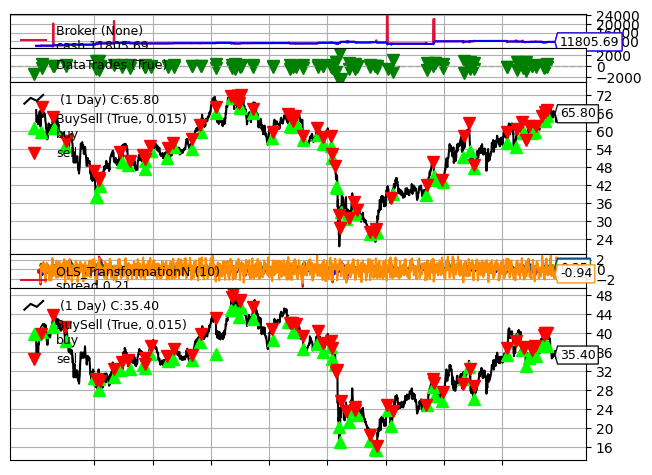

In [ ]:
def runstrategy(tickers, start, end, cash=10_000, commperc=0.0, stake=10, period=10, plot=True, numfigs=1):

    cerebro = bt.Cerebro()
    #fromdate = datetime.datetime.strptime(args.fromdate, '%Y-%m-%d')
    #todate = datetime.datetime.strptime(args.todate, '%Y-%m-%d')

    ticker_A, ticker_B = tickers
    data0 = bt.feeds.PandasData(dataname=yf.download(ticker_A, start, end))
    cerebro.adddata(data0)
    data1 = bt.feeds.PandasData(dataname=yf.download(ticker_B, start, end))
    cerebro.adddata(data1)


    cerebro.addstrategy(PairTradingStrategy,
                        period=period,
                        stake=stake)

    cerebro.broker.setcash(cash)
    cerebro.broker.setcommission(commission=commperc)


    cerebro.run()
    cerebro.plot(iplot=False, numfigs=numfigs, volume=False, zdown=False)

%matplotlib inline
runstrategy(chosen_pair, '2015-01-01', '2023-12-30')

The backtest graph visualizes the performance of the Pair Trading Strategy, highlighting the price movements of the two traded assets along with buy (green triangles) and sell (red triangles) signals. The z-score panel in the middle demonstrates how the strategy triggers trades based on the mean-reverting behavior identified by the OLS transformation. Frequent trading signals indicate active responses to z-score thresholds. The top panel shows the portfolio's cash balance and overall value, with the portfolio value exhibiting an upward trend despite some drawdowns, reflecting the strategy's profitability and risk. Overall, the backtest indicates that the strategy effectively exploits cointegration, leading to a net increase in portfolio value while showcasing the importance of risk management and transaction cost considerations.